## b) Fare amount, parsimonious model with start information

In [1]:
import yellowcab
import yellowcab.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
from numpy import mean

In [2]:
trip_data = yellowcab.io.read_all_files("parquet")

In [3]:
scaler = StandardScaler()
# fit with fare_amount
scaler.fit(np.array(trip_data.fare_amount).reshape(-1,1))
# transform the data
trip_data.fare_amount = scaler.transform(np.array(trip_data.fare_amount).reshape(-1,1))
# separate the independent and target variable 
train_X = trip_data[['trip_distance','congestion_surcharge','start_location_lat', 'end_location_long', 'end_location_lat']]
train_Y = trip_data['fare_amount']

train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.20,random_state=0)

#### Linear Regression

In [4]:
%%time

# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data (Linear Regression): ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data (Linear Regression): ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data (Linear Regression):  0.35875068634993057
RMSE on test data (Linear Regression):  0.5161983495755873
Wall time: 515 ms


#### Random Forest Regressor

In [5]:
%%time

# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=5)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data (Random Forest Regressor): ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data (Random Forest Regressor): ',  mean_squared_error(test_y, predict_test)**(0.5))

RMSE on train data (Random Forest Regressor):  0.30665425872237717
RMSE on test data (Random Forest Regressor):  0.4815724655265423
Wall time: 7min 4s


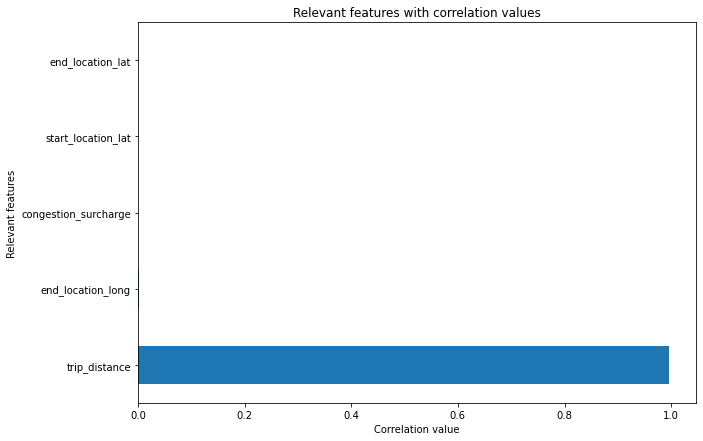

In [6]:
# plot importantance of features 

fig, axes = plt.subplots(1, 1,  figsize=(10, 7), gridspec_kw={'wspace':0.2})
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(5).plot(kind='barh');

axes.set_title('Relevant features with correlation values')
axes.set_xlabel('Correlation value')
axes.set_ylabel('Relevant features')


yellowcab.io.save_fig(fig, "feature_importance")
plt.show()

#### OLS, Lasso and Ridge Linear Regression

In [7]:
def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(trip_data[['trip_distance','congestion_surcharge','start_location_lat', 'end_location_long', 'end_location_lat']], 
                                                                trip_data['fare_amount'], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [8]:
%%time

models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge()}

lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(trip_data[['trip_distance','congestion_surcharge','start_location_lat', 'end_location_long', 'end_location_lat']], trip_data['fare_amount']).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(trip_data[['trip_distance','congestion_surcharge','start_location_lat', 'end_location_long', 'end_location_lat']], trip_data['fare_amount']).best_estimator_}

test(models2, trip_data)


Wall time: 10min 41s


,OLS,Lasso,Ridge
0,0.844915,0.842551,0.843810
1,0.842608,0.838873,0.846556


In [9]:
def test2(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(trip_data[['trip_distance']], 
                                                                trip_data['fare_amount'], 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [10]:
%%time

models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge()}

lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(trip_data[['trip_distance']], trip_data['fare_amount']).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(trip_data[['trip_distance']], trip_data['fare_amount']).best_estimator_}

test2(models2, trip_data)

Wall time: 5min 32s


,OLS,Lasso,Ridge
0,0.839898,0.840364,0.841654
1,0.843097,0.841309,0.836792


#### Best performing model

In [11]:
yellowcab.model.fare_amount.fare_amount_lasso_regression(x=trip_data[['trip_distance']], y=trip_data[['fare_amount']], train=True, load=False, save=False)

Best performing model with R2_train (0) and R2_test (1): 
 
 {'Lasso': [0.7947612513988983, 0.7987551556149817]}


## GridSearch on Lasso

In [3]:
%%time
import scipy
from sklearn.model_selection import RandomizedSearchCV
X = trip_data[['trip_distance']]
y = trip_data[['fare_amount']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
lasso_params = {'alpha':[0.001, 0.01, 0.01, 0.03]}
params_space = {'alpha': scipy.stats.expon(scale=0.03)}
# search_pipe = Pipeline(steps=[('scaler', StandardScaler()),
#                                   ('gridsearch', GridSearchCV(Lasso(),
#                                                               lasso_params,
#                                                               n_jobs=-1,
#                                                               cv=5,
#                                                               verbose=2))])
search_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                              ('gridsearch', RandomizedSearchCV(Lasso(),
                                                              params_space,
                                                              n_jobs=-1,
                                                              cv=5,
                                                              verbose=2))])
search_pipe.fit(X_train, y_train)
p_test = search_pipe.predict(X_test)
print(metrics.r2_score(y_test, p_test))
search_pipe['gridsearch'].best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7546501779303841
Wall time: 57.6 s


{'alpha': 0.0031464197041880587}

In [8]:
from yellowcab.model import fare_amount_lasso_regression

lasso_model = fare_amount_lasso_regression(x=X, y=y, train=True, load=False, save=True)

